Training using all data randomized

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb
import tqdm

import pydensecrf.densecrf as dcrf

In [3]:
import sys
sys.path.insert(0, 'code')
from models import *
from v13_deeplab import *

In [4]:
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
bs = 128
num_slice = 9
# STRIDE_SZ = 197
PATH = 'data/'

BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
# FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
# FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"
FMT_VALTRAIN_MUL_STORE = V5_IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = V5_IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

## Preprocessing

In [5]:
for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
    !python code/v5_im.py preproc_train {train_path}

2018-04-10 13:50:41,374 INFO Preproc for training on AOI_2_Vegas
2018-04-10 13:50:41,374 INFO Generate IMAGELIST csv ... skip
2018-04-10 13:50:41,374 INFO Generate IMAGELIST csv ... skip
2018-04-10 13:50:41,374 INFO Generate band stats csv (MUL) ... skip
2018-04-10 13:50:41,375 INFO Preproc for training on AOI_2_Vegas ... done
2018-04-10 13:50:42,608 INFO Preproc for training on AOI_3_Paris
2018-04-10 13:50:42,608 INFO Generate IMAGELIST csv ... skip
2018-04-10 13:50:42,608 INFO Generate IMAGELIST csv ... skip
2018-04-10 13:50:42,608 INFO Generate band stats csv (MUL) ... skip
2018-04-10 13:50:42,609 INFO Preproc for training on AOI_3_Paris ... done
2018-04-10 13:50:43,928 INFO Preproc for training on AOI_4_Shanghai
2018-04-10 13:50:43,928 INFO Generate IMAGELIST csv ... skip
2018-04-10 13:50:43,928 INFO Generate IMAGELIST csv ... skip
2018-04-10 13:50:43,928 INFO Generate band stats csv (MUL) ... skip
2018-04-10 13:50:43,928 INFO Preproc for training on AOI_4_Shanghai ... done
2018-04

In [ ]:
train_path = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
!parallel python code/v12_im_deeplab.py preproc_train \{\} ::: {train_path}

2018-04-10 13:56:37,416 INFO Preproc for training on AOI_2_Vegas
2018-04-10 13:56:37,434 INFO Generate MASK (valtrain)
2018-04-10 13:56:37,434 INFO prep_image_mask for AOI_2_Vegas
2018-04-10 13:56:38,142 INFO Prepare image container: data/working/images/v12/valtrain_AOI_2_Vegas_mask.h5
 67%|██████████████████████████▎            | 1819/2695 [01:12<00:35, 25.01it/s]/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tables/group.py:489: PerformanceWarning: group ``/`` is exceeding the recommended maximum number of children (16384); be ready to see PyTables asking for *lots* of memory and possibly slow I/O.
  PerformanceWarning)
100%|███████████████████████████████████████| 2695/2695 [01:46<00:00, 25.22it/s]
2018-04-10 13:58:25,036 INFO Generate MASK (valtest)
2018-04-10 13:58:25,037 INFO prep_image_mask for AOI_2_Vegas
2018-04-10 13:58:25,568 INFO Prepare image container: data/working/images/v12/valtest_AOI_2_Vegas_mask.h5
100%|███████████████████████████████████████| 1156/1

In [6]:
for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
    !python code/v12_im_deeplab.py preproc_train {train_path}

2018-04-10 13:56:37,416 INFO Preproc for training on AOI_2_Vegas
2018-04-10 13:56:37,434 INFO Generate MASK (valtrain)
2018-04-10 13:56:37,434 INFO prep_image_mask for AOI_2_Vegas
2018-04-10 13:56:38,142 INFO Prepare image container: data/working/images/v12/valtrain_AOI_2_Vegas_mask.h5
 67%|██████████████████████████▎            | 1819/2695 [01:12<00:35, 25.01it/s]/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tables/group.py:489: PerformanceWarning: group ``/`` is exceeding the recommended maximum number of children (16384); be ready to see PyTables asking for *lots* of memory and possibly slow I/O.
  PerformanceWarning)
100%|███████████████████████████████████████| 2695/2695 [01:46<00:00, 25.22it/s]
2018-04-10 13:58:25,036 INFO Generate MASK (valtest)
2018-04-10 13:58:25,037 INFO prep_image_mask for AOI_2_Vegas
2018-04-10 13:58:25,568 INFO Prepare image container: data/working/images/v12/valtest_AOI_2_Vegas_mask.h5
100%|███████████████████████████████████████| 1156/1

### Overload

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [11]:
datapath = ['data/train/AOI_3_Paris_Train']
datapaths = ['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']

In [63]:
area_id = directory_name_to_area_id(datapath[0])
prefix = area_id_to_prefix(area_id)
f = tb.open_file(FMT_VALTRAIN_MUL_STORE.format(prefix))

In [49]:
class H5Dataset(BaseDataset):
    def __init__(self, idxs, y, transform, datapaths=datapaths, is_rgb=True):
        self.s = y
        area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
        self.prefixes = [area_id_to_prefix(area_id) for area_id in area_ids]
        self.is_rgb = is_rgb
        self.file_lists = [FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) for prefix in self.prefixes]
        self.x_h5_lists = [FMT_VALTRAIN_MUL_STORE.format(prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_MUL_STORE.format(prefix) for prefix in self.prefixes]
        self.y_h5_lists = [FMT_VALTRAIN_MASK_STORE.format(prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_MASK_STORE.format(prefix) for prefix in self.prefixes]
        self.idxs = idxs # idx of trn or val. 0 ... len-1. Generate by permutation
        if transform is not None:
            super().__init__(transform)
        
        # open all files
        self.x_h5_lists_open = [tb.open_file(o) for o in self.x_h5_lists]
        self.df_lists = [pd.read_csv(o) for o in self.file_lists]

        # choose next h5 after one is exhausted
        self.ns = []
        for file_list in self.file_lists:
            df = pd.read_csv(file_list)
            self.ns.append(df.shape[0])
        self.ns = np.array(self.ns) # number of pre-crop images
        self.cum_ns = np.cumsum(self.ns)
        
    def get_sz(self): return self.transform.sz
    
    def get_file_idx(self,i):
        idx_file = np.argmax(i + 1 <= self.cum_ns)
        if idx_file == 0:
            idx_im = i
        else:
            idx_im = i - self.cum_ns[idx_file - 1]
        return idx_file, idx_im
    
    def get_im(self, i, is_y):
        idx_file, idx_im = self.get_file_idx(i)
        h5_list_open = self.y_h5_lists_open if is_y else self.x_h5_lists_open
        f = h5_list_open[idx_file]
        df_list = self.df_lists[idx_file]
        slice_pos = idx_im % num_slice
        
        im = np.array(f.get_node('/' + df_list.iloc[idx_im // num_slice][0] + '_' + str(slice_pos)))
        
        if self.is_rgb:
            # Or other bands
            im = im[...,:3]
        return im.astype('float')
        
    def get_x(self, i): return self.get_im(i, False)
        
    def get_y(self, i): return self.get_im(i, True)
        
    def get_c(self): return 1
        
    def get_n(self): return self.idxs.shape[0]

#     def resize_imgs(self, targ, new_path):
#         dest = resize_imgs(self.fnames, targ, self.path, new_path)
#         return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

    @staticmethod
    def get_ns(datapaths=datapaths):
        return H5Dataset(None, None, None, datapaths=datapaths).cum_ns[-1]

In [14]:
cut_base = 8
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model.module))
        return [c[:cut_base],
               c[cut_base:]]

In [15]:
def jaccard_coef(y_true, y_pred, thresh=0.5):
    smooth = 1e-12
    y_pred = (y_pred > 0).float()
    plt.subplot(121)
    plt.imshow(to_np(y_pred[0,0]))
    plt.subplot(122)
    plt.imshow(to_np(y_true[0]))
    y_true = (y_true > 0.5).float()
    intersection = torch.sum(y_true * y_pred)
    sum_ = torch.sum(y_true + y_pred)
    print(intersection, sum_)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac.mean()

    smooth = 1e-12
    ma = torch.max(y_pred)
    mi = torch.min(y_pred)
    y_pred = (y_pred - mi) / (ma - mi) > thresh


def jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_true = torch.round(y_true)
    y_pred_pos = torch.round(torch.clamp(y_pred, 0, 1))
    intersection = torch.sum(y_true * y_pred_pos)
    sum_ = torch.sum(y_true + y_pred_pos)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac.mean()

Variable containing:
 13277
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 2.6185e+05
[torch.cuda.FloatTensor of size 1 (GPU 0)]



Variable containing:
1.00000e-02 *
  5.3414
[torch.cuda.FloatTensor of size 1 (GPU 0)]

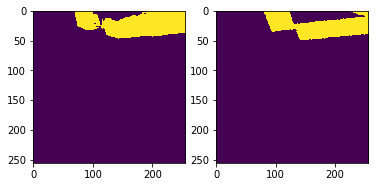

In [118]:
jaccard_coef(V(y), preds)

In [50]:
def get_mean_image(area_id):
    prefix = area_id_to_prefix(area_id)

    with tb.open_file(FMT_IMMEAN.format(prefix), 'r') as f:
        im_mean = np.array(f.get_node('/immean'))
    return im_mean

def get_md_model(datapaths, device_ids=list(range(7))):
    aug_tfms=transforms_top_down
    for o in aug_tfms: o.tfm_y = 4
    inception_stats = 
    tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    
    ns = H5Dataset.get_ns(datapaths)
    print('Total number of images', ns)
    x_idx = np.arange(ns)
    # 80:20 split
    val_idxs = np.random.permutation(x_idx)[:int(ns * 0.8)]
    [[trn_x, val_x]] = split_by_idx(val_idxs, x_idx)
    
    datasets = ImageData.get_ds(H5Dataset, (trn_x, None), (val_x, None), tfms)
    md = ImageData('data', datasets, bs, num_workers=16, classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    net = to_gpu(UNet16(pretrained='vgg'))
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    return md, models, denorm

In [51]:
def expanded_loss(pred, target):
#     pred = torch.clamp(pred, 0, 1)
    return F.binary_cross_entropy_with_logits(pred[:,0], target)

In [52]:
md, model, denorm = get_md_model(datapath)

Total number of images 1148


In [53]:
learn=ConvLearner(md, model)
learn.opt_fn=optim.Adam
learn.crit=expanded_loss
learn.metrics=[jaccard_coef, jaccard_coef_int]

In [51]:
learn.model.module.load_state_dict(torch.load('data/models/unfreezed_1.h5'))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 53%|█████▎    | 348/651 [05:00<04:21,  1.16it/s, loss=209]   

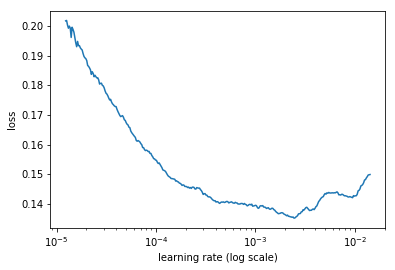

In [20]:
learn.lr_find()
learn.sched.plot()

In [27]:
learn.sched

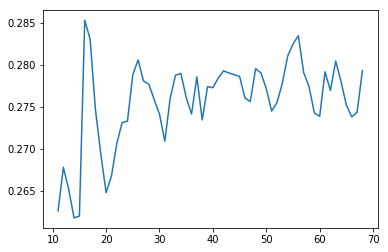

In [48]:
learn.sched.plot_loss()

In [52]:
lr = 1e-5
learn.freeze_to(1)
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  0%|          | 0/434 [00:00<?, ?it/s]


Exception in thread Thread-7040:
Traceback (most recent call last):
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   jaccard_coef jaccard_coef_int 
    0      0.150676   0.084876   0.077312   0.077312  
    1      0.13898    0.082876   0.077013   0.077013         
    2      0.135383   0.081974   0.076891   0.076891         
    3      0.13262    0.080946   0.076772   0.076772         
    4      0.130334   0.080756   0.076698   0.076698         
    5      0.130774   0.08093    0.076646   0.076646         
    6      0.12988    0.08081    0.076646   0.076646         
    7      0.129189   0.080455   0.076617   0.076617         



[0.08045537, 0.07661723373643563, 0.07661723373643563]

In [54]:
learn.save('freezed_1')

In [ ]:
x, y = md.trn_dl.get_batch(range(9))

In [ ]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
    plt.imshow(y[i-1])
#     plt.imshow(to_np(learn.model(V(x[i-1][None]))).squeeze())

In [ ]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
#     plt.imshow(y[i-1])
    pred = to_np(learn.model(V(x[i-1][None]))).squeeze()
#     pred = np.clip(pred, 0, 1)
    plt.imshow(pred)

In [55]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/3,lr]) / 5

In [ ]:
learn.fit(lrs,5,cycle_len=40,use_clr=(20,8))

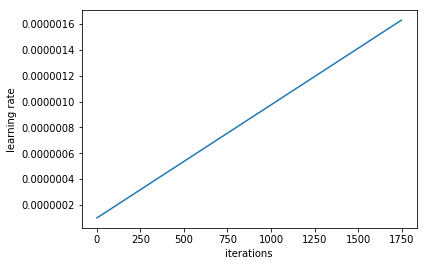

In [61]:
learn.sched.plot_lr()

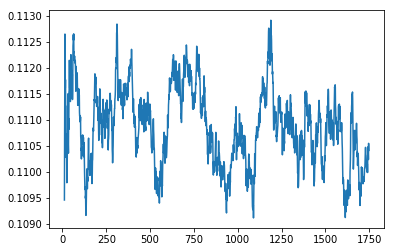

In [62]:
learn.sched.plot_loss()

In [60]:
learn.save('unfreezed_2')

In [54]:
learn.load('unfreezed_2')

In [57]:
x, y = md.trn_dl.get_batch(np.arange(1, 10) * 4)
preds = learn.model(V(x))

NoSuchNodeError: group ``/`` does not have a child named ``/AOI_3_Paris_img1818_4``

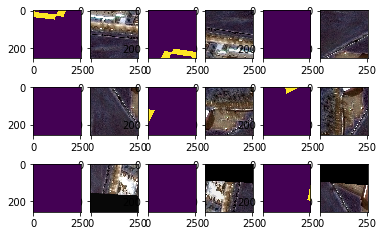

In [68]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
    plt.imshow(y[i-1])
#     plt.imshow(to_np(learn.model(V(x[i-1][None]))).squeeze())

In [137]:
learn.predict()

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

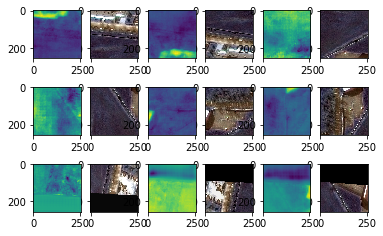

In [69]:
for i in range(1, 10):
    plt.subplot(3, 6, i*2)
    plt.imshow(denorm(x[i-1])[0])
    plt.subplot(3, 6, i*2-1)
#     plt.imshow(y[i-1])
    pred = to_np(learn.model(V(x[i-1][None]))).squeeze()
#     pred = np.clip(pred, 0, 1)
    plt.imshow(pred)

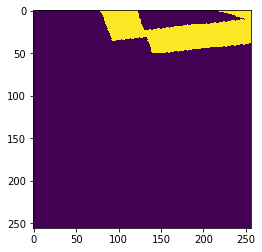

In [128]:
plt.imshow(to_np(y[0]))

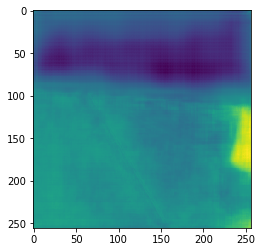

In [126]:
plt.imshow(to_np(pred))

In [ ]:
t = to_np(learn.model(V(x[1-1][None]))).squeeze()
ma = np.max(t)
mi = np.min(t)
ta = (t - mi) / (ma - mi)
print(ta)

In [ ]:
plt.imshow(denorm(x[1-1])[0])

In [ ]:
plt.imshow(t>0.5)

In [ ]:
smooth = 1e-12
intersection = torch.sum(y_true * y_pred)
sum_ = torch.sum(y_true + y_pred)
jac = (intersection + smooth) / (sum_ - intersection + smooth)
print(jac)

## CRF

In [ ]:
import numpy as np
import pydensecrf.densecrf as dcrf

# Example using the DenseCRF2D code
n_labels = 2
d = dcrf.DenseCRF2D(sz, sz, n_labels)

# get unary potentials (neg log probability)
U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=HAS_UNK)
d.setUnaryEnergy(U)

# This adds the color-independent term, features are the locations only.
d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

# This adds the color-dependent term, i.e. features are (x,y,r,g,b).
d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
normalization=dcrf.NORMALIZE_SYMMETRIC)

## Ditched experiments

In [ ]:
# # rgb scaled
# def get_rgb_scaled(datapath):
#     area_id = directory_name_to_area_id(datapath)
#     prefix = area_id_to_prefix(area_id)
    
#     X_val = []
#     fn_im = FMT_VALTEST_IM_STORE.format(prefix)
#     with tb.open_file(fn_im, 'r') as f:
#         for idx, image_id in enumerate(df_test.ImageId.tolist()):
#             im = np.array(f.get_node('/' + image_id))
#             im = np.swapaxes(im, 0, 2)
#             im = np.swapaxes(im, 1, 2)
#             X_val.append(im)
#     X_val = np.array(X_val)

#     y_val = []
#     fn_mask = FMT_VALTEST_MASK_STORE.format(prefix)
#     with tb.open_file(fn_mask, 'r') as f:
#         for idx, image_id in enumerate(df_test.ImageId.tolist()):
#             mask = np.array(f.get_node('/' + image_id))
#             mask = (mask > 0.5).astype(np.uint8)
#             y_val.append(mask)
#     y_val = np.array(y_val)
#     y_val = y_val.reshape((-1, 1, INPUT_SIZE, INPUT_SIZE))
#     return X_val, y_val

In [ ]:
# (trn_x,trn_y), (val_x,val_y) = get_dataset(datapath)

In [ ]:
def merge_file_list():
    df = pd.DataFrame()
    # clear file
    df.to_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
    for datapath in datapaths:
        area_id = directory_name_to_area_id(datapath)        
        prefix = area_id_to_prefix(area_id)
        fn_train = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
        df_train = pd.read_csv(fn_train)
#         fn_a = FMT_VALTRAIN_IMAGELIST_PATH_ALL
#         fn_im = FMT_VALTRAIN_MUL_STORE.format(prefix)
        fn_test = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix)
        df_test = pd.read_csv(fn_test)
        df = df.append(df_train).append(df_test)
        
    df.to_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
        

In [ ]:
import traceback
def merge_im(rgb=False):
    if rgb:
        fn_store_w = FMT_VALTRAIN_IM_STORE_ALL
    else:
        fn_store_w = FMT_VALTRAIN_MUL_STORE_ALL
        
    with tb.open_file(fn_store_w, 'w') as fw:
        for datapath in datapaths:
            try:
                area_id = directory_name_to_area_id(datapath)        
                prefix = area_id_to_prefix(area_id)

                # valtrain + valtest
                for (fn_store, fn_list) in [(FMT_VALTRAIN_MUL_STORE.format(prefix), FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)),
                                         (FMT_VALTEST_MUL_STORE.format(prefix), FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix))]:
                    df_list = pd.read_csv(fn_list, index_col='ImageId')
                    with tb.open_file(fn_store, 'r') as fr:
                        for idx, image_id in tqdm.tqdm(enumerate(df_list.index), total=df_list.shape[0]):
                            for slice_pos in range(9):
                                slice_id = image_id + '_' + str(slice_pos)
                                im = np.array(fr.get_node('/' + slice_id))
                                im = np.swapaxes(im, 0, 2)
                                im = np.swapaxes(im, 1, 2)
                                if rgb:
                                    im = im[:3,...]
                                atom = tb.Atom.from_dtype(im.dtype)
                                filters = tb.Filters(complib='blosc', complevel=9)
                                ds = fw.create_carray(fw.root, slice_id, atom, im.shape,
                                                     filters=filters)
                                ds[:] = im
            except Exception as e:
                traceback.print_exc()
                print(datapath, e)

In [ ]:
# merge_file_list()
# df = pd.read_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
# df.head()

In [ ]:
# merge_im(True)
# merge_im(False) # Too big

In [11]:
class ArraysSingleDataset(BaseDataset):
    def __init__(self, x, y, transform):
        self.x = x; self.y = y
        self.num_groups = len(x)
        self.sz = x[0].shape[1]
        self.ns = np.array([o.shape[0] for o in x])
        self.cum_ns = np.cumsum(self.ns * num_slice)
        super().__init__(transform)

        
    def get_im(self, i, is_y):
        idx_file, idx_im = self.get_file_idx(i)
        if is_y:
            im = self.y[idx_file][idx_im//num_slice]
        else:
            im = self.x[idx_file][idx_im//num_slice]
        slice_pos = idx_im % num_slice
        a = np.sqrt(num_slice)
        cut_i = slice_pos // a
        cut_j = slice_pos % a
        stride = (self.sz - sz) // a
        cut_x = int(cut_j * stride)
        cut_y = int(cut_i * stride)
        return im[cut_x:cut_x + sz, cut_y:cut_y + sz]
        
            
    def get_x(self, i): return self.get_im(i, False)
    def get_y(self, i): return self.get_im(i, True)
        
    def get_file_idx(self, i):
        idx_file = np.argmax(i + 1 <= self.cum_ns)
        if idx_file == 0:
            idx_im = i
        else:
            idx_im = i - self.cum_ns[idx_file - 1]
        return idx_file, idx_im
    
    def get_n(self): return self.cum_ns[-1]
    
    def get_sz(self): return self.sz
        
    def get_c(self): return 1
    def denorm(self, arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
#         return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [8]:
# memory dataset
def get_dataset(datapaths):
    area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
    prefix = [area_id_to_prefix(area_id) for area_id in area_ids]
    trn_x, trn_y = [], []
    val_x, val_y = [], []
    for area_id in area_ids:
        trn_x_t, trn_y_t = get_valtrain_data(area_id)
        trn_x_t = trn_x_t[:,:3]; trn_x_t = np.moveaxis(trn_x_t, 1, -1).astype('float') # --> [bs, h, w, ch]
        trn_y_t = trn_y_t[:,:3]; trn_y_t = np.moveaxis(trn_y_t, 1, -1).astype('float')
        trn_y_t = np.broadcast_to(trn_y_t, (trn_y_t.shape[0], 256, 256, 3))
        trn_x += [trn_x_t]; trn_y += [trn_y_t]
        
        val_x_t, val_y_t = get_valtest_data(area_id)
        val_x_t = val_x_t[:,:3]; val_x_t = np.moveaxis(val_x_t, 1, -1).astype('float')
        val_y_t = val_y_t[:,:3]; val_y_t = np.moveaxis(val_y_t, 1, -1).astype('float')
        val_y_t = np.broadcast_to(val_y_t, (val_y_t.shape[0], 256, 256, 3))
        val_x += [val_x_t]; val_y += [val_y_t]
#     trn_x, trn_y = np.array(trn_x), np.array(trn_y)
#     val_x, val_y = np.array(val_x), np.array(val_y)
    return (trn_x,trn_y), (val_x,val_y)
